#  Stock Analysis & Prediction Notebook

This notebook performs:
1. Data download & cleaning (via `yfinance`)
2. Visualizations with **matplotlib**
3. Technical indicators (moving averages, returns, volatility)
4. **scikit-learn** models (Linear Regression, Random Forest)
5. **Prophet** time-series forecast (optional, with fallback)
6. **LSTM** deep learning prediction (TensorFlow/Keras)

**Note:** Install required packages if missing. Cells include safe fallbacks so the notebook still runs if some libraries aren't available.

## 0. Setup & Imports

In [3]:
# If needed, uncomment to install locally in your Jupyter environment:
# %pip install yfinance pandas numpy matplotlib scikit-learn mplfinance
# %pip install prophet  # optional; may require build tools (cmdstan)
# %pip install tensorflow  # optional for LSTM

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Optional/extra packages with safe imports
try:
    import yfinance as yf
except Exception as e:
    raise RuntimeError("yfinance is required. Please install with: %pip install yfinance") from e

try:
    import mplfinance as mpf
    HAS_MPLFINANCE = True
except Exception:
    HAS_MPLFINANCE = False

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prophet (optional)
try:
    from prophet import Prophet
    HAS_PROPHET = True
except Exception:
    HAS_PROPHET = False

# TensorFlow/Keras (optional)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    from sklearn.preprocessing import MinMaxScaler
    HAS_TF = True
except Exception:
    HAS_TF = False

print("Versions -> pandas:", pd.__version__, "| numpy:", np.__version__)


Versions -> pandas: 2.3.1 | numpy: 2.3.2


## 1. Download Reliance Data

In [4]:
TICKER = "RELIANCE.NS"  # NSE: Reliance Industries Limited
START = "2015-01-01"
END = None  # None = up to today

df = yf.download(TICKER, start=START, end=END, auto_adjust=True)
if df.empty:
    raise RuntimeError("No data downloaded. Check ticker or internet connection.")

# Basic checks
display(df.head())
display(df.tail())
print("Shape:", df.shape)
print("Date range:", df.index.min().date(), "->", df.index.max().date())

# Keep a copy
raw_df = df.copy()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2015-01-01,189.999817,190.877171,189.090366,189.657446,2963643
2015-01-02,189.496948,191.743828,189.229471,190.042616,7331366
2015-01-05,187.421249,190.641775,187.046767,189.379239,10103941
2015-01-06,178.915222,186.811376,178.037869,186.169417,18627980
2015-01-07,182.809830,183.772776,179.107845,179.129243,20720312


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2025-08-08,1362.358887,1391.641835,1359.569977,1379.490416,8793606
2025-08-11,1380.685669,1382.478557,1355.785119,1364.550161,9997486
2025-08-12,1374.908813,1396.323287,1369.729426,1376.402846,12244664
2025-08-13,1377.099976,1386.263451,1372.020288,1382.478519,7457021
2025-08-14,1373.800049,1380.699951,1370.099976,1377.300049,7126128


Shape: (2623, 5)
Date range: 2015-01-01 -> 2025-08-14


## 2. Feature Engineering & Indicators

In [5]:
df = raw_df.copy()

# Daily returns
df['Return'] = df['Close'].pct_change()

# Moving averages
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()

# Rolling volatility (21-day, annualized)
df['Volatility21'] = df['Return'].rolling(21).std() * np.sqrt(252)

# Drop initial NaNs for indicators
df = df.dropna()
display(df.head())


Price,Close,High,Low,Open,Volume,Return,MA20,MA50,MA200,Volatility21
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,
Date,,,,,,,,,,
2015-10-21,206.933151,211.223486,206.499781,207.041490,14404450,-0.001777,192.804273,192.484879,195.075206,0.305125
2015-10-23,207.073990,210.844298,203.932076,208.872473,12153422,0.000681,193.971658,192.427458,195.160577,0.294154
2015-10-26,204.300430,208.666602,203.964565,208.428257,10938775,-0.013394,194.973821,192.327133,195.234594,0.267200
2015-10-27,203.585373,205.470527,203.119501,203.422865,11601798,-0.003500,196.081075,192.312615,195.315415,0.268808
2015-10-28,203.022003,204.744649,201.494382,203.011169,11958727,-0.002767,197.193748,192.328217,195.435948,0.260328


## 3. Visualizations (Matplotlib)

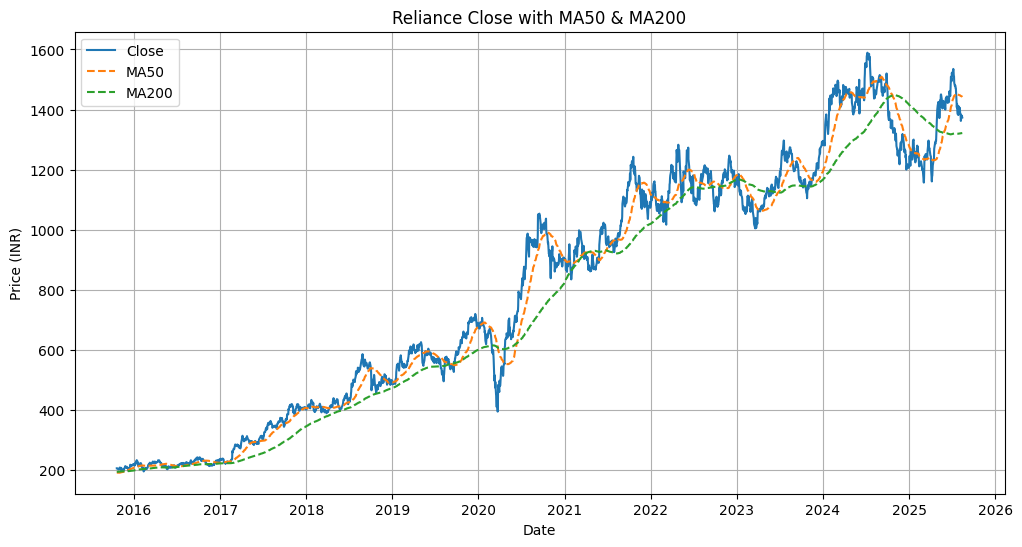

In [6]:
# Close with MAs
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['MA50'], label='MA50', linestyle='--')
plt.plot(df.index, df['MA200'], label='MA200', linestyle='--')
plt.title('Reliance Close with MA50 & MA200')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


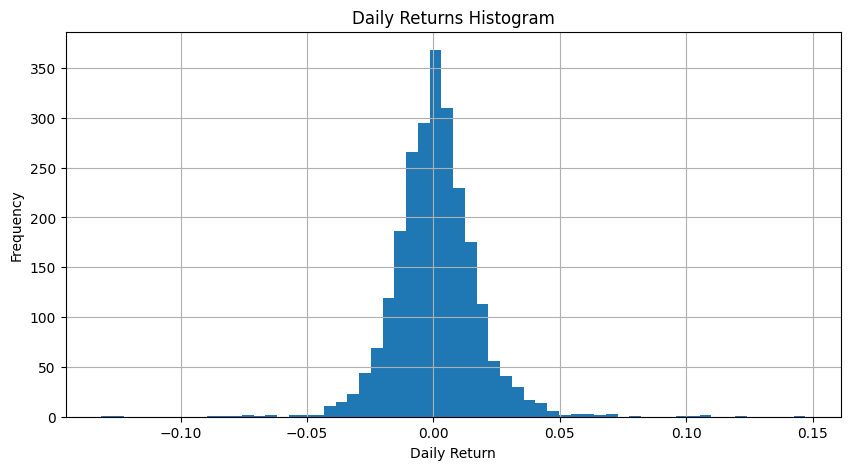

In [7]:
# Daily return distribution (histogram)
plt.figure(figsize=(10,5))
plt.hist(df['Return'].dropna(), bins=60)
plt.title('Daily Returns Histogram')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


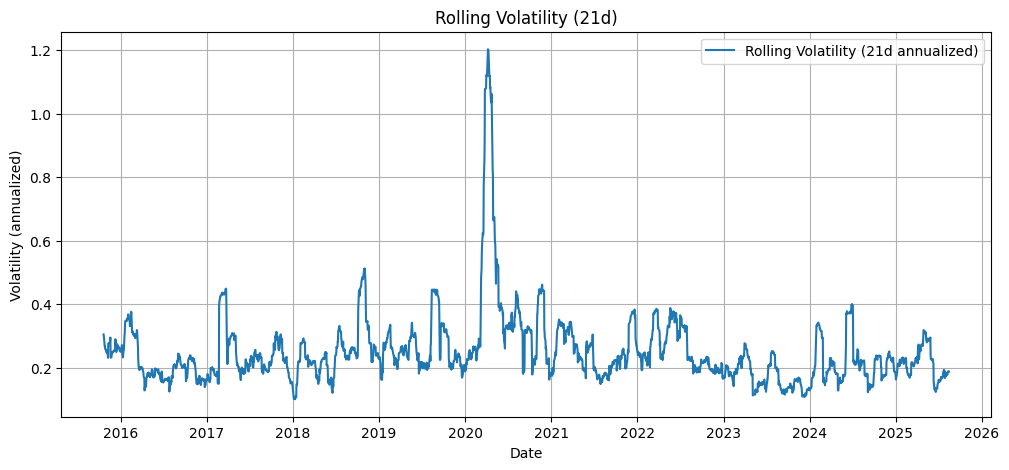

In [8]:
# Volatility
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Volatility21'], label='Rolling Volatility (21d annualized)')
plt.title('Rolling Volatility (21d)')
plt.xlabel('Date')
plt.ylabel('Volatility (annualized)')
plt.legend()
plt.grid(True)
plt.show()


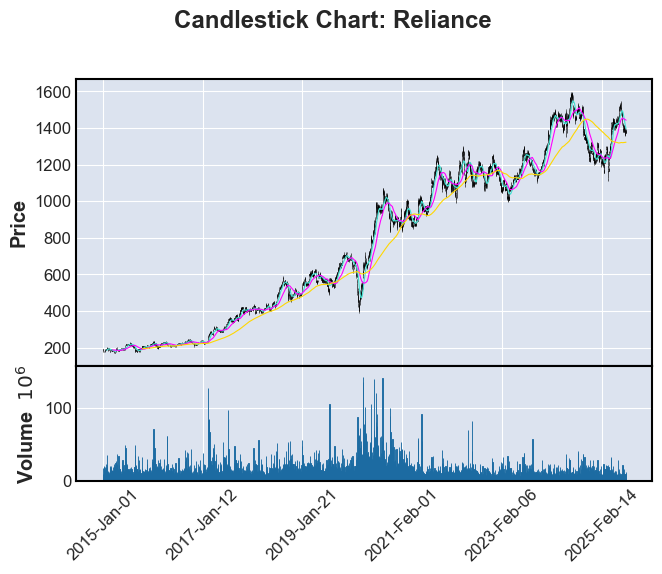

In [10]:
# Optional candlestick chart with mplfinance
if HAS_MPLFINANCE:
    # Flatten columns if needed and rename to standard OHLCV
    df_mpf = raw_df.copy()
    if isinstance(df_mpf.columns[0], tuple):
        df_mpf.columns = [col[0] for col in df_mpf.columns]
    df_mpf = df_mpf[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
    mpf.plot(df_mpf, type='candle', volume=True, mav=(20,50,200), title='Candlestick Chart: Reliance')
else:
    print("mplfinance not installed; skipping candlestick chart.")


## 4. scikit-learn Models (Next-day Price Prediction)
We train models to predict **next day's Close** using current day's features.

Linear Regression -> RMSE: 18.21198068133643 | R2: 0.9770379463703307
Random Forest     -> RMSE: 141.01780310660757 | R2: -0.3767156654496613


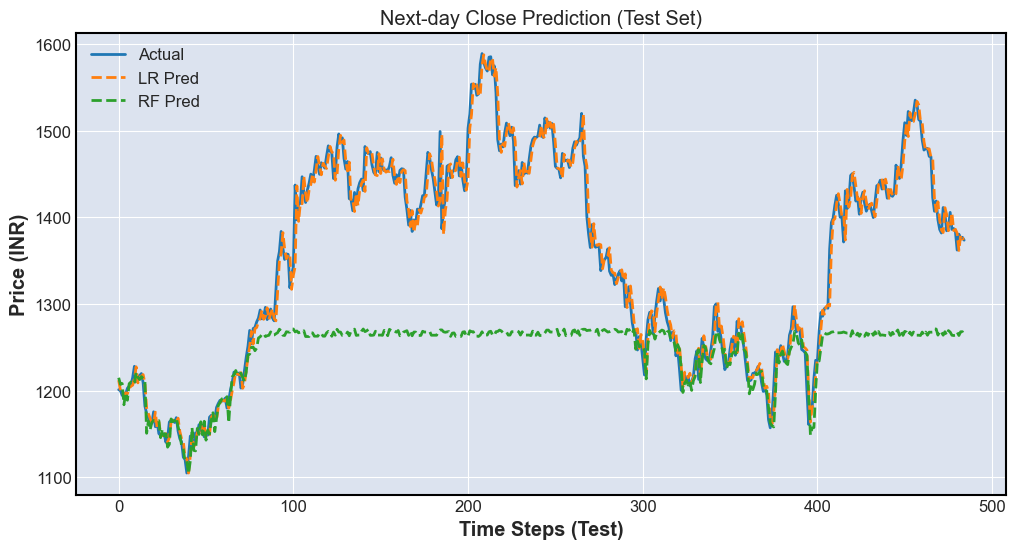

In [11]:
# Prepare supervised learning dataset
data_ml = df.copy()
data_ml['Target'] = data_ml['Close'].shift(-1)  # next day's close
data_ml = data_ml.dropna()

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MA50', 'MA200', 'Volatility21']
X = data_ml[features].values
y = data_ml['Target'].values

# Time-aware split (no shuffling)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# Metrics
def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))

print("Linear Regression -> RMSE:", rmse(y_test, pred_lr), "| R2:", r2_score(y_test, pred_lr))
print("Random Forest     -> RMSE:", rmse(y_test, pred_rf), "| R2:", r2_score(y_test, pred_rf))

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(pred_lr, label='LR Pred', linestyle='--')
plt.plot(pred_rf, label='RF Pred', linestyle='--')
plt.title('Next-day Close Prediction (Test Set)')
plt.xlabel('Time Steps (Test)')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


## 5. Prophet Forecast (Optional)
Forecasts future values based on historical Close price. Skips gracefully if Prophet isn't available.

In [12]:
if HAS_PROPHET:
    df_p = raw_df[['Close']].reset_index().rename(columns={'Date':'ds','Close':'y'})
    # Prophet prefers daily frequency and may need no missing dates
    # Reindex to daily freq and forward-fill
    df_p = df_p.set_index('ds').asfreq('D').ffill().reset_index()

    m = Prophet(daily_seasonality=True)
    m.fit(df_p)

    future = m.make_future_dataframe(periods=30)  # forecast next 30 days
    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    plt.title('Prophet Forecast: Close')
    plt.show()

    fig2 = m.plot_components(forecast)
    plt.show()
else:
    print("Prophet is not installed; skipping Prophet forecast. Install with: %pip install prophet")


Prophet is not installed; skipping Prophet forecast. Install with: %pip install prophet


## 6. LSTM Deep Learning Model (Optional)
Sequence model using the last 60 days of Close to predict next day Close. Skips gracefully if TensorFlow isn't available.

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0101
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0017
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0012
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0013
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0012
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0010
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 9.7922e-04
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.0050e-04
Epoch 9/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.9972e-04
Epoch 10/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 8.3497e-04
Epoch 11/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 7.5818e-04
Epoch 12/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.5125e-04
Epoch 13/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 7.4959e-04
Epoch 14/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 7.7679e-04
Epoch 15/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 

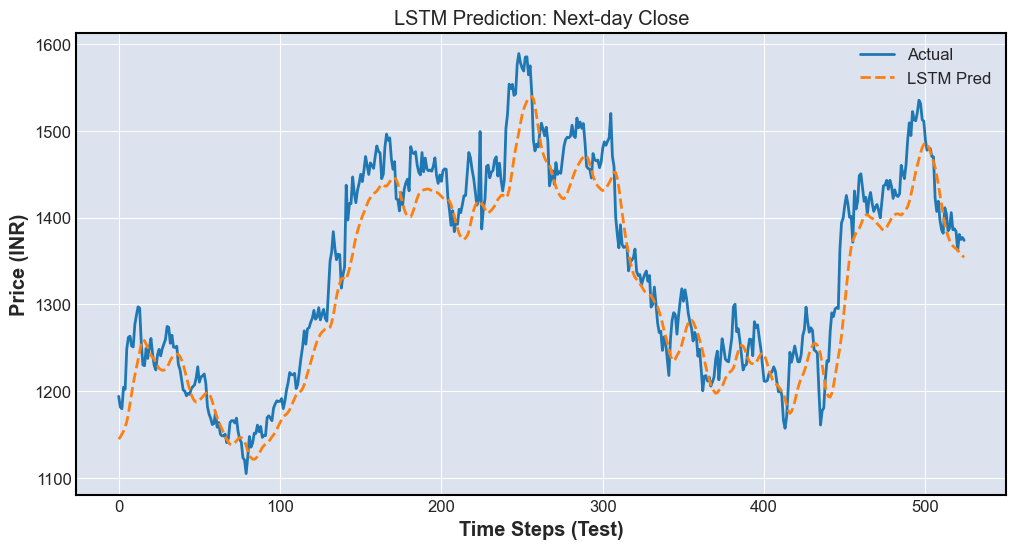

In [13]:
if HAS_TF:
    close_series = raw_df[['Close']].copy()

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(close_series)

    lookback = 60
    split = int(len(scaled)*0.8)
    train_data = scaled[:split]
    test_data = scaled[split - lookback:]

    def make_sequences(arr, lb):
        Xs, ys = [], []
        for i in range(lb, len(arr)):
            Xs.append(arr[i-lb:i, 0])
            ys.append(arr[i, 0])
        Xs, ys = np.array(Xs), np.array(ys)
        return Xs.reshape((Xs.shape[0], Xs.shape[1], 1)), ys

    X_train, y_train = make_sequences(train_data, lookback)
    X_test, y_test_scaled = make_sequences(test_data, lookback)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback,1)),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1)

    # Predict and inverse transform
    pred_scaled = model.predict(X_test)
    pred = scaler.inverse_transform(pred_scaled)
    y_true = close_series.iloc[split:].values  # true unscaled

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='Actual')
    plt.plot(pred, label='LSTM Pred', linestyle='--')
    plt.title('LSTM Prediction: Next-day Close')
    plt.xlabel('Time Steps (Test)')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("TensorFlow not installed; skipping LSTM. Install with: %pip install tensorflow")


## 7. Save Processed Data

In [14]:
out_csv = "Reliance_processed.csv"
df.to_csv(out_csv)
print(f"Saved engineered dataset to {out_csv}")


Saved engineered dataset to Reliance_processed.csv


## 8. Notes
- All charts use matplotlib. If you prefer interactive charts, consider Plotly.
- Model results are **illustrative**, not financial advice.
- Improve models with more features (technical indicators, macro variables), hyperparameter tuning, and walk-forward validation.